#### **ENCM 509 Final Project**
##### Face Detection and Recognition
##### Authors: Tania Rizwan, Muhammad Haris Kashif

In [ ]:
# Choose 5-10 photos with one or two faces in it.
# • Convert to gray-scale.
# • Perform some pre-processing (such as histogram equalization, smoothing) if needed. This
# depends on the image quality.
# • Performs Face detection:
# – Investigate the original Haar cascades for the frontal face detection, by choosing 2-3 various
# values of the parameters of scalefactor, and minNeighbors. Compare the results, and draw
# conclusions.
# – Investigate the LBP-based Haar cascades for the frontal face detection, by choosing 2-3
# various values of the parameters of scale ratio, step ratio, min size, max size. Compare
# the results, and draw conclusions.
# • Evaluate the number of errors in face detection using the above approaches. Draw conclusions.
# • Creation of a Precision vs. Recall graph for each algorithm (with their best performing param-
# eters). Which algorithm is superior in performance?

# RESOURCES FOR CODE 
# https://www.datacamp.com/tutorial/face-detection-python-opencv#face-detection

# Citations
# https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# https://pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/

#### **Imports**

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
import cv2

#### **1. Preprocessing**
TODO: Fill this out nicely later but steps are:
1. Load 5 images for subject 1 and 2
2. Equalize them thru adaptive hist equalization
3. Normalize them 

In [105]:
# HELPER FUNCTIONS

def image_normalizer(S, M, irow, icol):
    """
    Normalize each image in a provided dataset, where the dataset is a matrix of images

    Parameters:
    S - matrix filled with images from dataset
    M - number of images in dataset
    irow, icol - dimensions of images in dataset (should be same for all images)

    Returns:
    S - normalized matrix of images from dataset
    """

    # 1. Determine global mean and std
    mu = np.mean(S)
    std = np.std(S)

    # 2. Normalize each image
    for i in range(S.shape[1]):
        temp = S[:, i] # Load image i
        m = np.mean(temp) # Mean of image
        st = np.std(temp) # Std of image
        # Determine new pixel intensities
        S[:,i] = (temp - m) * std / st + mu # Modify original dataset matrix
    
    # 3. Plot normalized dataset
    plt.figure(figsize = (12, 3))
    for i in range(M):
        img = np.reshape(S[:,i], (irow, icol))

        plt.subplot(1, M, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.suptitle('Normalized Images with Mean:  %.1f - Std: %.1f' % (np.mean(img), np.std(img)), fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle


    # 4. Plot histogram of dataset 
    plt.figure()
    plt.hist(S, bins = 10, density = False)
    plt.title("Histogram of Dataset (Normalized)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

    return S


In [106]:
def image_equalizer(S, M, irow, icol):
    """  
    Equalize each image in a provided dataset, where the dataset is a matrix of images

    Parameters:
    S - matrix filled with images from dataset
    M - number of images in dataset
    irow, icol - dimensions of images in dataset (should be same for all images)

    Returns:
    S - Equalized matrix of images from dataset
    """

    # 1. Apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize = (3,3)) # Instantiate the CLAHE algorithm from OpenCv
    for i in range(M):
        temp = S[:, i] # Load image i (flattened)
        img = np.reshape(temp, (irow, icol)) # Reshape to 2D
        img_uint8 = img.astype(np.uint8) # Convert to uint8
        equalized_img = clahe.apply(img_uint8)
        S[:,i]  = equalized_img.flatten() # Store back as a flattened vector
    
    # 2. Plot equalized dataset
    plt.figure(figsize = (12, 3))
    for i in range(M):
        img = np.reshape(S[:,i], (irow, icol))

        plt.subplot(1, M, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.suptitle('Equalized Images', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle

    # 3. Plot updated histogram
    plt.figure()
    plt.hist(S, bins = 10, density = False)
    plt.title("Histogram of Dataset (Equalized)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

    
    return S

In [107]:
# Choose 5 photos belonging to two faces each

# Specify path for dataset
path = './ATT dataset/'

# Load images for a subject
def load_images(S, subject_dir, M):
    """
    Load images from the ATT dataset and place them in an array

    Parameters:
    S - empty matrix of size (rows x cols) x M to store images
    subject_dir - directory for subject to load images from
    M - number of images to load

    Returns:
    S - matrix filled with images from dataset
    """


    plt.figure(figsize=(12, 3))
    for i in range(1,M+1):
        img = imread(path + f'{subject_dir}/' + '{}.pgm'.format(i), as_gray=True)
        irow, icol = img.shape

        plt.subplot(1, M, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Image {i}")

        # reshape(img',irow*icol,1);
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        S[:,i-1] = temp[:,0]
    # after finishing the sequence, S is a N1*N2xM matrix
    plt.suptitle(f"Dataset for Subject {subject_dir}")
    plt.tight_layout()  # Leave space for suptitle

    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))
    return S

In [108]:
def visualize_ground_truth(gt, S, M, irow, icol):
    """  
    Plot images with the ground truth bonding boxes overlayed.

    Parameters:
    S - processed image matrix (flattened images stored as columns)
    M - number of images in the dataset
    irow - number of rows in each image
    icol - number of columns in each image
    gt - matrix of ground truth bounding boxes
    """

    plt.figure(figsize = (15, 3))

    for i in range(M):
        # Retrive and reshape the i-th image
        temp = S[:, i] # Load image i (flattened)
        img = np.reshape(temp, (irow, icol)) # Reshape to 2D
        img_uint8 = img.astype(np.uint8) # Convert to uint8

        # Create subplot for image 
        ax = plt.subplot(1, M, i + 1)
        ax.imshow(img, cmap = 'gray')
        ax.axis('off')
        ax.set_title(f"Image {i + 1}")

        # Loop over the ground truth box for this image and overlay it
        for bbox in gt[i]:
            x, y, w, h = bbox
            # Create a rectangle patch
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
            # Add to the plot
            ax.add_patch(rect)
    
    plt.suptitle("Images with Ground Truth Bounding Boxes", fontsize = "16")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Size of each image: (112, 92) 10304


/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_44925/3396437402.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_44925/1292757249.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_44925/1683690699.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


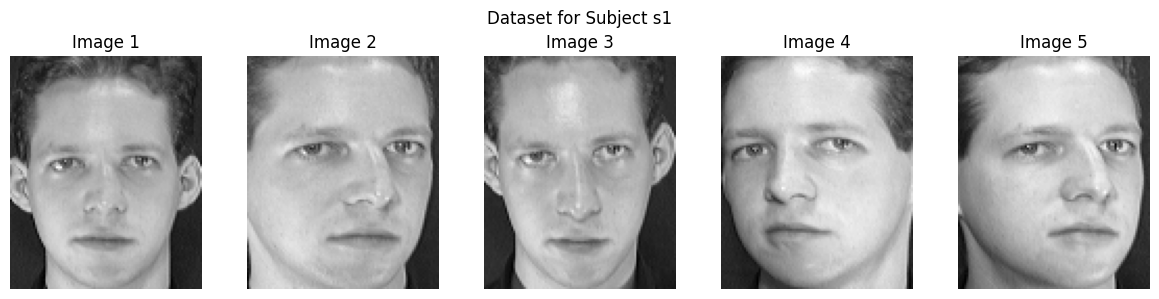

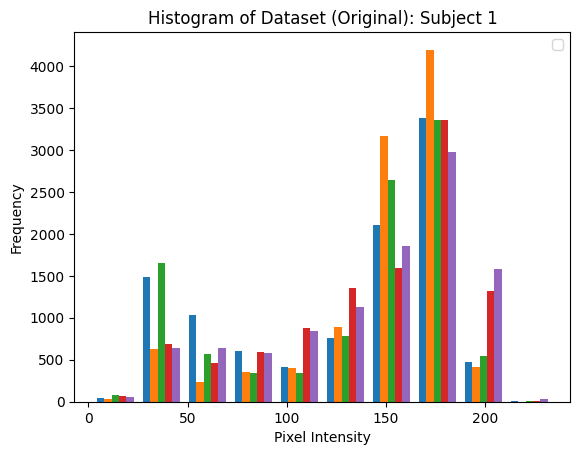

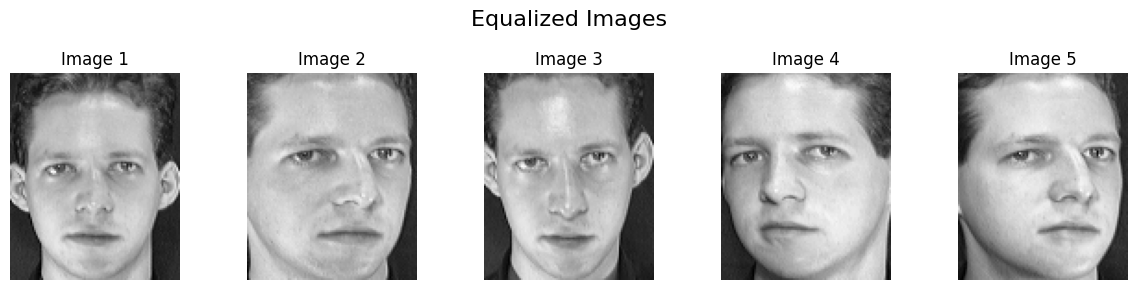

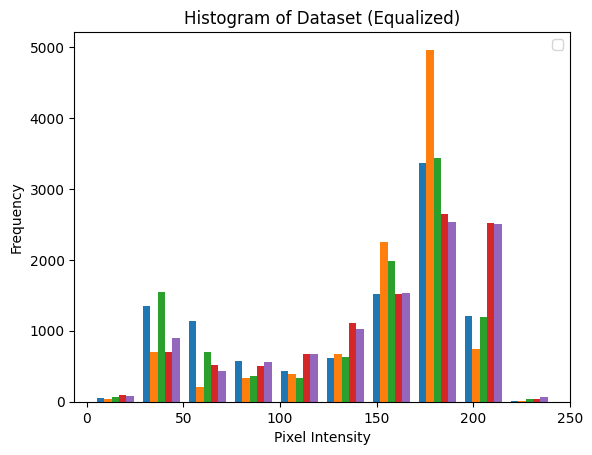

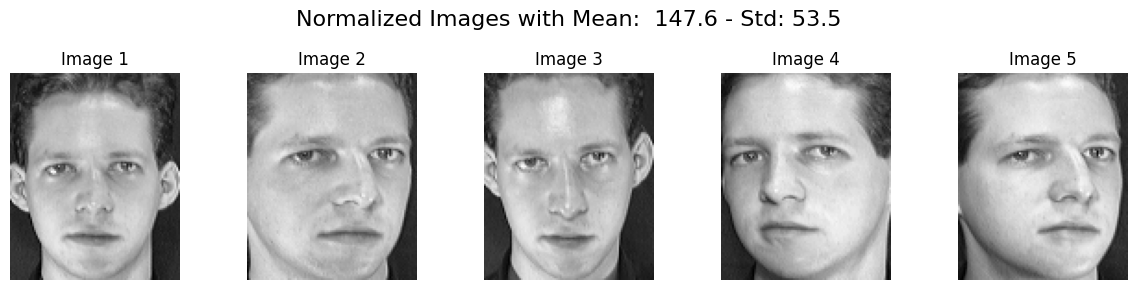

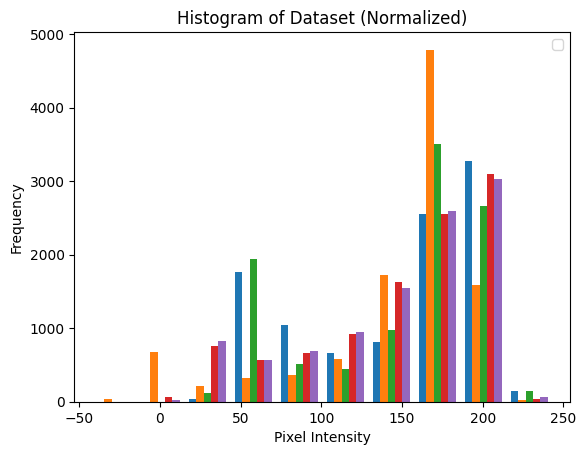

In [109]:
# Load and preprocess images for Subject 1

# 1. Load images 
M = 5 # Num of photos to load
img1 = imread(path + 's1/' + '1.pgm', as_gray=True) # Get dimensions of one image
irow1, icol1 = img1.shape # Get the number of rows (irow) and columns (icol). These values must to be the same for all images
S1 = np.zeros((irow1*icol1, M)) # Allocation of matrix that will have all images
S1 = load_images(S=S1, subject_dir='s1', M = 5)

# 2. Histogram of original dataset 
plt.figure()
plt.hist(S1, bins = 10, density = False)
plt.title("Histogram of Dataset (Original): Subject 1")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()

# 3. Equalize the image for contrast enhancement and plot histogram
S1_eq = image_equalizer(S = S1, M = M, irow = irow1, icol = icol1) 

# 4. Normalize the image and plot histogram
S1_processed = image_normalizer(S = S1_eq, M = M, irow = irow1, icol = icol1)

In [110]:
gt_subject1 = [
    [(12, 20, 68, 84)],  # Image 1
    [(5, 20, 85, 84)],  # Image 2
    [(12, 20, 68, 84)],  # Image 3
    [(2, 20, 68, 84)],  # Image 4
    [(5, 20, 80, 84)]   # Image 5
]

visualize_ground_truth(gt = gt_subject1, M = M, irow = irow1, icol = icol1, S = S1_processed)

Size of each image: (112, 92) 10304


/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_44925/259138680.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_44925/1292757249.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_44925/1683690699.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


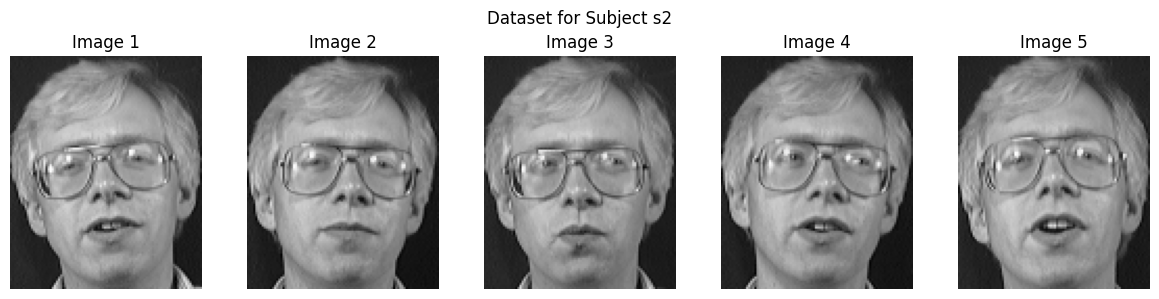

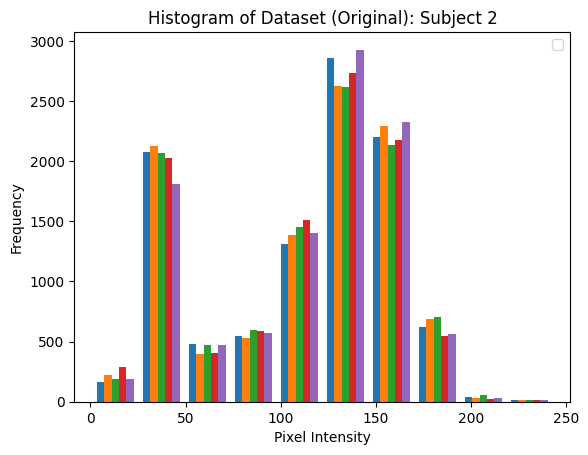

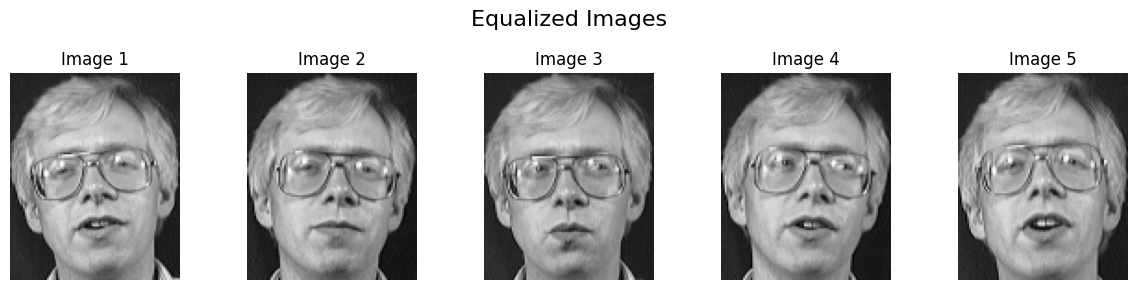

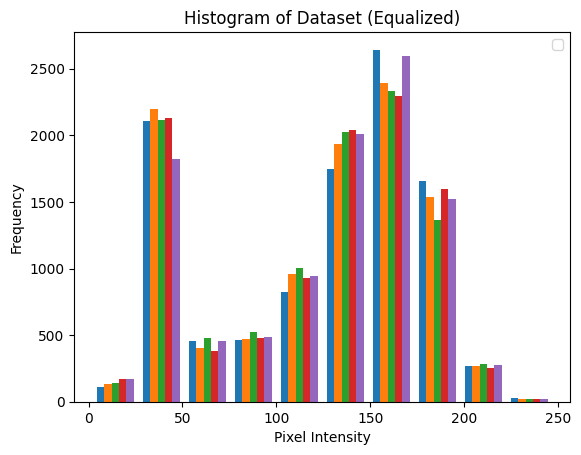

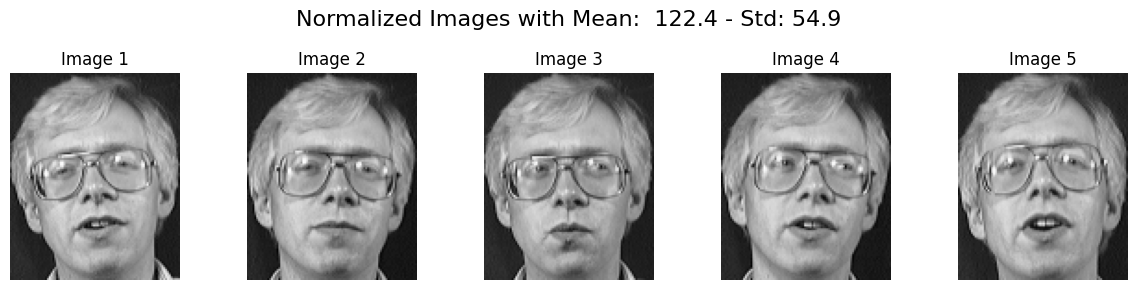

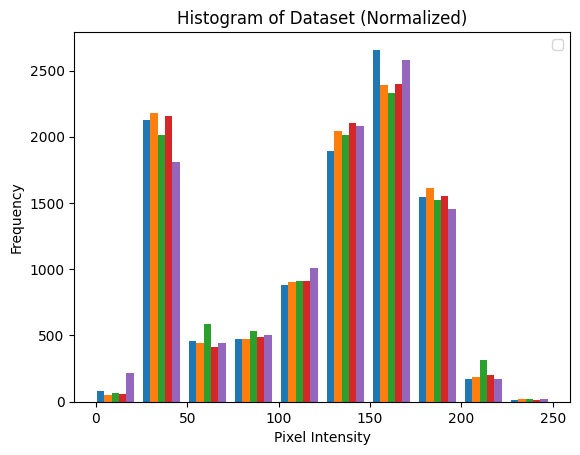

In [111]:
# Load and preprocess images for Subject 2

# 1. Load images 
M = 5 # Num of photos to load
img2 = imread(path + 's2/' + '1.pgm', as_gray=True) # Get dimensions of one image
irow2, icol2 = img2.shape # Get the number of rows (irow) and columns (icol). These values must to be the same for all images
S2 = np.zeros((irow2*icol2, M)) # Allocation of matrix that will have all images
S2 = load_images(S=S2, subject_dir='s2', M = 5)

# 2. Histogram of original dataset 
plt.figure()
plt.hist(S2, bins = 10, density = False)
plt.title("Histogram of Dataset (Original): Subject 2")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()

# 3. Equalize the image for contrast enhancement and plot histogram
S2_eq = image_equalizer(S = S2, M = M, irow = irow2, icol = icol2) 

# 4. Normalize the image and plot histogram
S2_processed = image_normalizer(S = S2_eq, M = M, irow = irow2, icol = icol2)


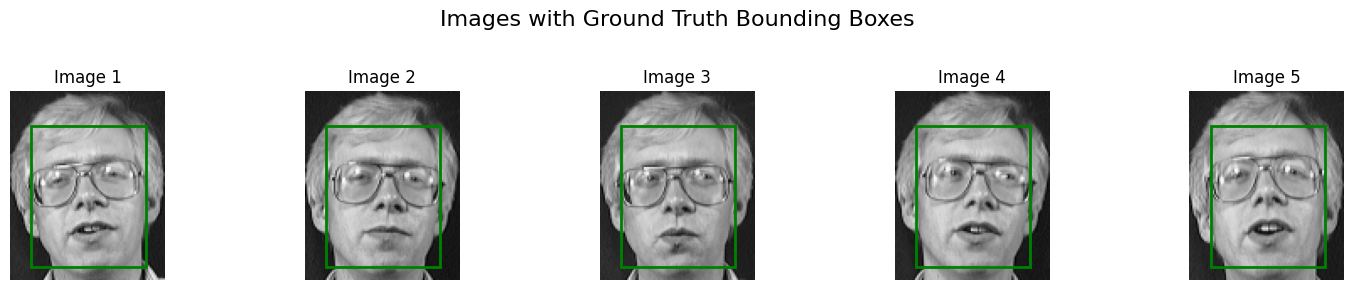

In [112]:
gt_subject2 = [
    [(12, 20, 68, 84)],  # Image 1
    [(12, 20, 68, 84)],  # Image 2
    [(12, 20, 68, 84)],  # Image 3
    [(12, 20, 68, 84)],  # Image 4
    [(12, 20, 68, 84)]   # Image 5
]

visualize_ground_truth(gt = gt_subject2, M = M, irow = irow2, icol = icol2, S = S2_processed)

#### **Performance Metrics**

In [113]:

def compute_iou(boxA, boxB):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.
    
    Parameters:
    boxA: ground-truth box
    boxB: resulting box from ML model

    Returns:
    IoU Value: float
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# CITATION: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [114]:
def evaluate_detection(ground_truths, detections, thresholds=[0.25, 0.5, 0.75]):
    """
    Evaluate precision and recall for each IoU threshold.

    Parameters:
    ground_truths - list of true boxes per image
    detections - list of predicted boxes per image

    Returns:
    precision_dict, recall_dict - metrics per threshold
    """
    precision_dict = {}
    recall_dict = {}

    for thresh in thresholds:
        TP = 0
        FP = 0
        FN = 0

        for gt_boxes, pred_boxes in zip(ground_truths, detections):
            matched = [False] * len(gt_boxes)

            for pred in pred_boxes:
                found_match = False
                for i, gt in enumerate(gt_boxes):
                    if not matched[i] and compute_iou(pred, gt) >= thresh:
                        TP += 1
                        matched[i] = True
                        found_match = True
                        break
                if not found_match:
                    FP += 1

            FN += matched.count(False)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        precision_dict[thresh] = precision
        recall_dict[thresh] = recall

    return precision_dict, recall_dict


#### **Algorithm 1: Haar-Cascades**

In [115]:
# Citations:
# https://www.datacamp.com/tutorial/face-detection-python-opencv#face-detection


# Load the pre-trained Haar Cascade classifier
frontal_haar_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

profile_haar_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_profileface.xml'
)

In [133]:
# Perform face detection

def haar_cascade_detector(subj, S, M, irow, icol, scaleFactor, minNeighbors, minSize):
    """  
    Perform face detection using the Haar Cascade frontal face classifier.

    Parameters:
    subj - name of subject
    S - processed image matrix (flattened images stored as columns)
    M - number of images in the dataset
    irow - number of rows in each image
    icol - number of columns in each image
    scaleFactor - controls how the image is scaled during detection.
    minNeighbors - determines how many neighbors each detected rectangle should have
    minSize - minimum size of detected objects in form (x1, x2)

    ReturnsL
    all_detections - a list of bounding-box lists for each of the M images. Each item is a list of (x, y, w, h) tuples
    """

    all_detections = []

    plt.figure(figsize = (15, 3))
    for i in range(M):
        temp = S[:,i] # Load image i (flattened) - 1D vector
        img = np.reshape(temp, (irow, icol)) # Reshape to 2D matrix
        img = img.astype(np.uint8) # Convert to uint8
        
        # Detect faces
        face_frontal = frontal_haar_cascade.detectMultiScale(img, scaleFactor = scaleFactor, minNeighbors = minNeighbors, minSize = minSize)
        face = face_frontal

        # if face is None:
        #     face_profile = profile_haar_cascade.detectMultiScale(img, scaleFactor = 1.05, minNeighbors = 3, minSize = (30, 30))
        #     face = face_profile

        # Convert the result into a list of tuples
        detected_boxes = [tuple(bbox) for bbox in face]
        
        # Add to overall list
        all_detections.append(detected_boxes)

        for (x, y, w, h) in face:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 0), 2)


        plt.subplot(1, M, i + 1) # Create subplot as: 1 row, M columns, index i + 1
        plt.imshow(img, cmap = 'gray')
        plt.axis('off')
    
    plt.suptitle(f"Haar-Cascade Face Detection for Subject {subj}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle    plt.tight_layout()
    plt.show()

    return all_detections




Params: 1.01, 0, (30, 30)
Precision: {0.25: 0.009140767824497258, 0.5: 0.009140767824497258, 0.75: 0.005484460694698354}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}


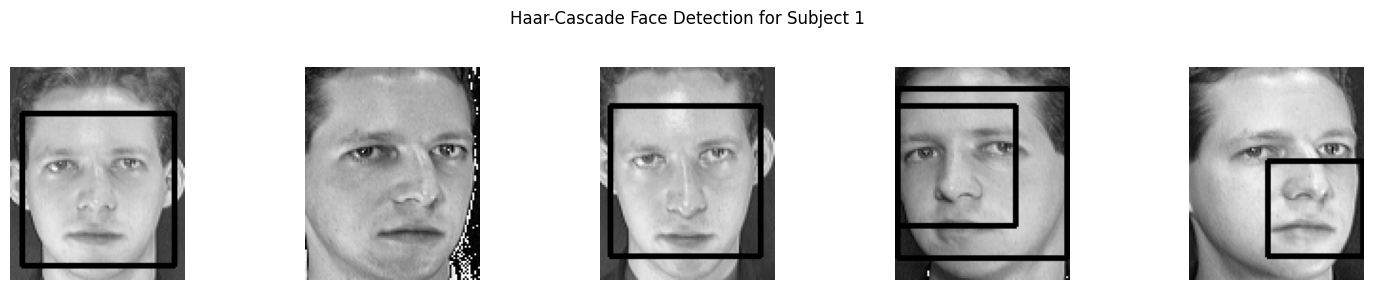

Params: 1.01, 5, (30, 30)
Precision: {0.25: 0.8, 0.5: 0.6, 0.75: 0.4}
Recall: {0.25: 0.8, 0.5: 0.6, 0.75: 0.4}


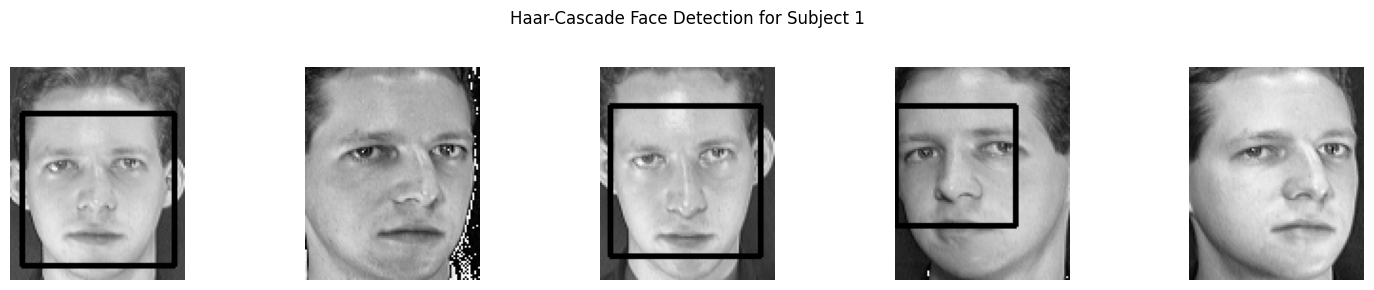

Params: 1.01, 10, (30, 30)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6666666666666666}
Recall: {0.25: 0.6, 0.5: 0.6, 0.75: 0.4}


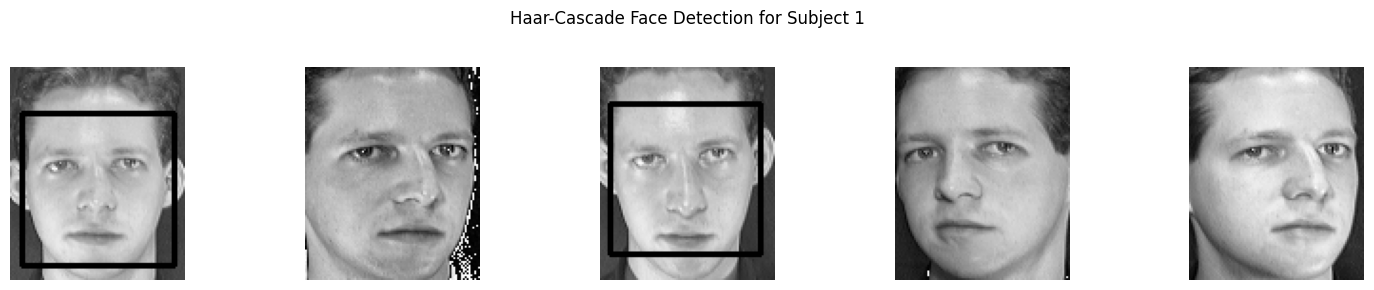

Params: 1.05, 5, (10, 10)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.4, 0.5: 0.4, 0.75: 0.4}


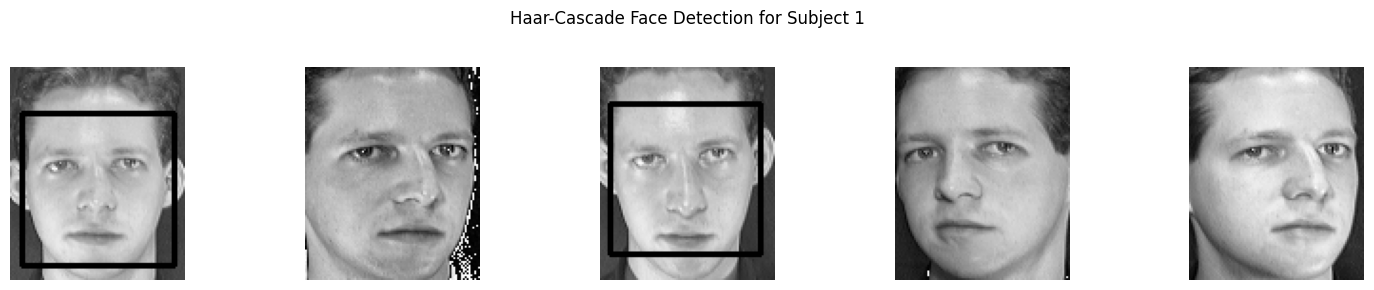

Params: 1.05, 10, (30, 30)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.4, 0.5: 0.4, 0.75: 0.4}


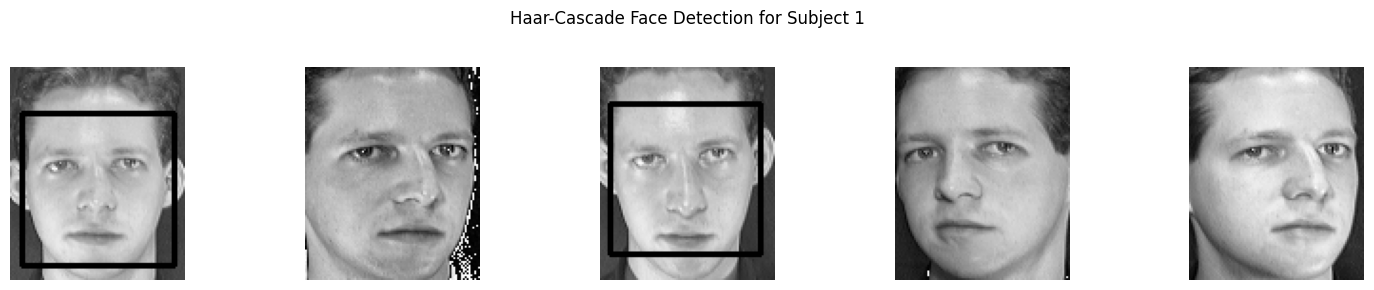

Params: 1.05, 10, (5, 5)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.4, 0.5: 0.4, 0.75: 0.4}


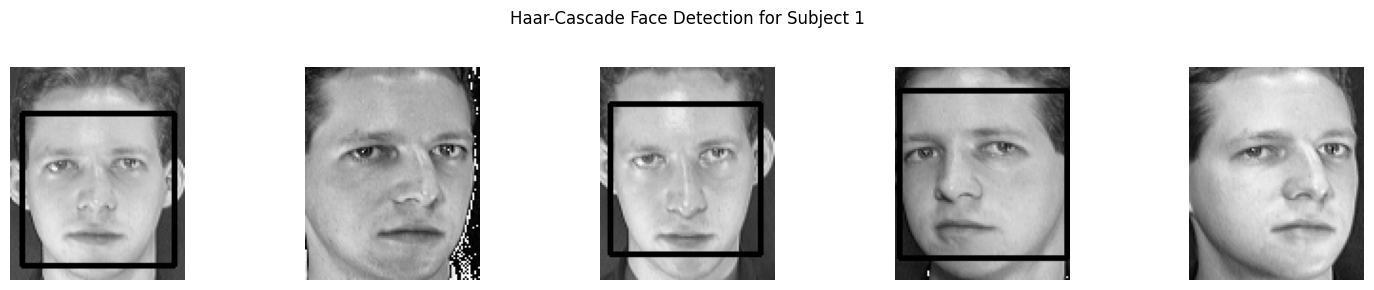

Params: 1.05, 3, (30, 30)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6666666666666666}
Recall: {0.25: 0.6, 0.5: 0.6, 0.75: 0.4}


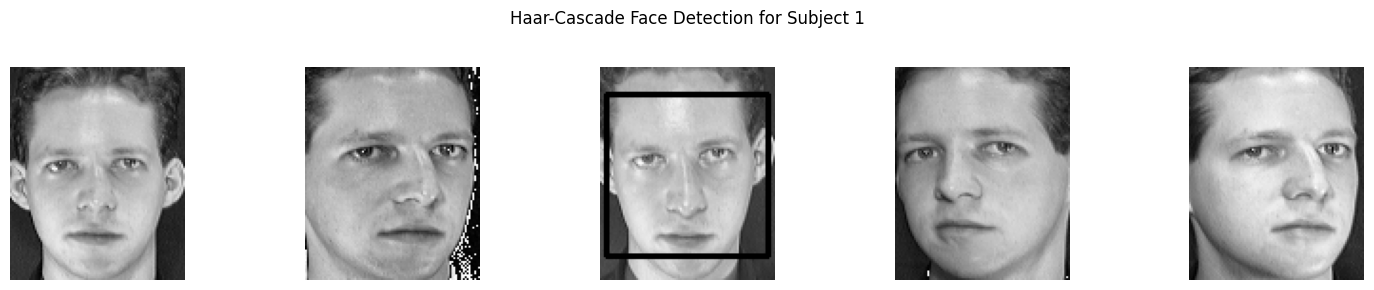

Params: 1.3, 10, (30, 30)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.0}


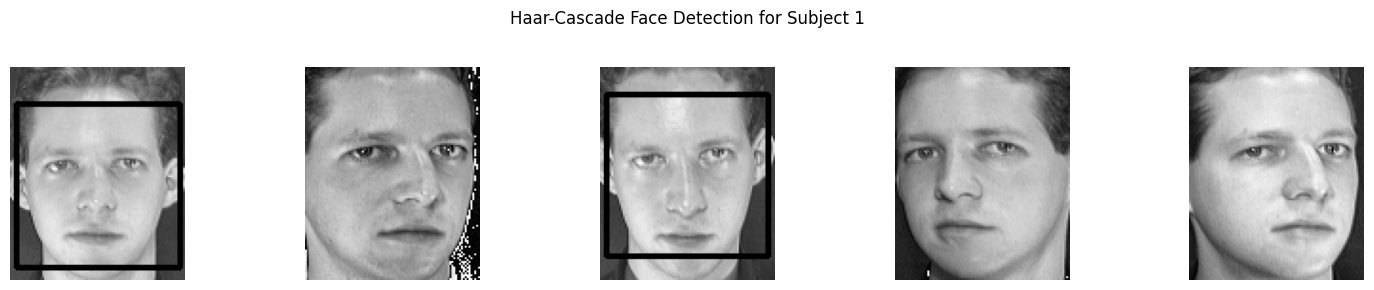

Params: 1.3, 3, (40, 40)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.5}
Recall: {0.25: 0.4, 0.5: 0.4, 0.75: 0.2}


In [144]:
params_list = [
    (1.01, 0, (30, 30)),
    (1.01, 5, (30, 30)),
    (1.01, 10, (30, 30)),
    (1.05, 5, (10, 10)),
    (1.05, 10, (30, 30)),
    (1.05, 10, (5, 5)),
    (1.05, 3, (30, 30)),
    (1.3, 10, (30, 30)),
    (1.3, 3, (40, 40))
]


for scaleFactor, minNeighbors, minSize in params_list:
    detections_s1 = haar_cascade_detector(subj = 1, S = S1_processed, M = M, irow = irow1, icol = icol1, scaleFactor = scaleFactor, minNeighbors = minNeighbors, minSize = minSize)
    precision, recall = evaluate_detection(gt_subject1, detections_s1)
    print(f"Params: {scaleFactor}, {minNeighbors}, {minSize}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

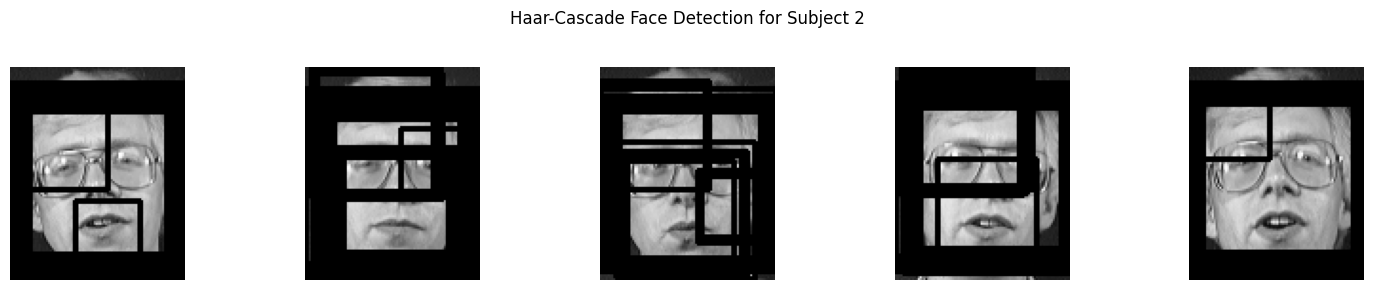

Params: 1.01, 0, (30, 30)
Precision: {0.25: 0.017921146953405017, 0.5: 0.017921146953405017, 0.75: 0.017921146953405017}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}


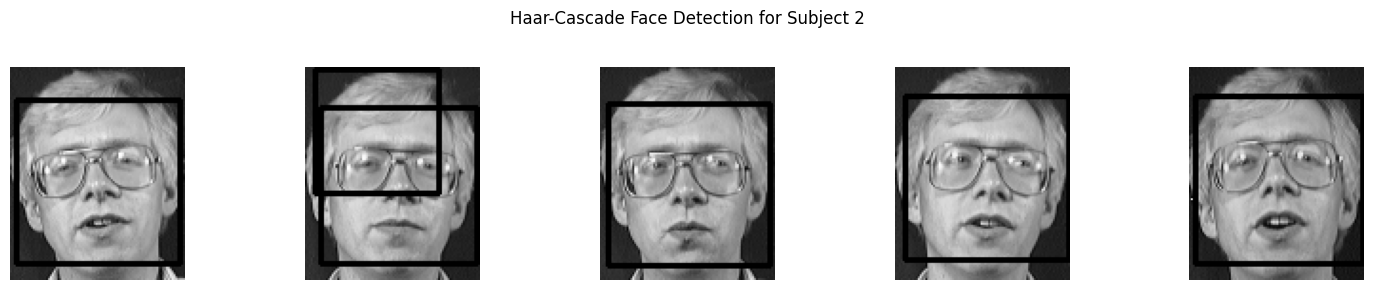

Params: 1.01, 5, (30, 30)
Precision: {0.25: 0.8333333333333334, 0.5: 0.8333333333333334, 0.75: 0.5}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}


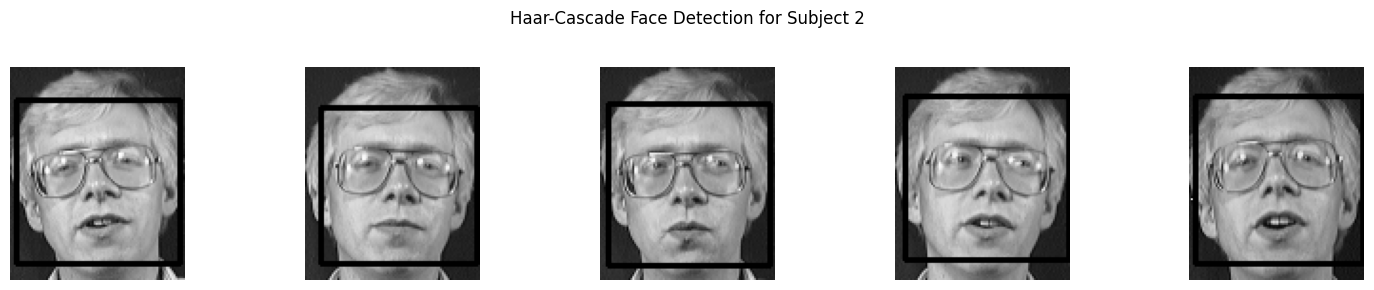

Params: 1.01, 10, (30, 30)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}


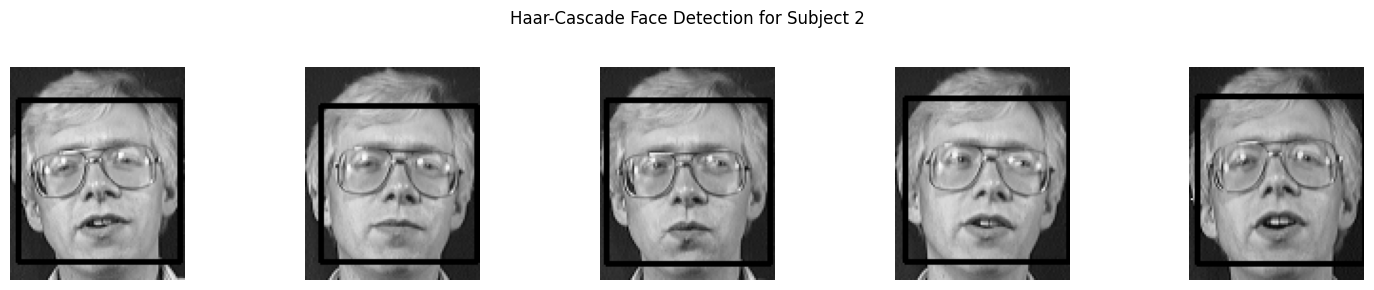

Params: 1.05, 5, (10, 10)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}


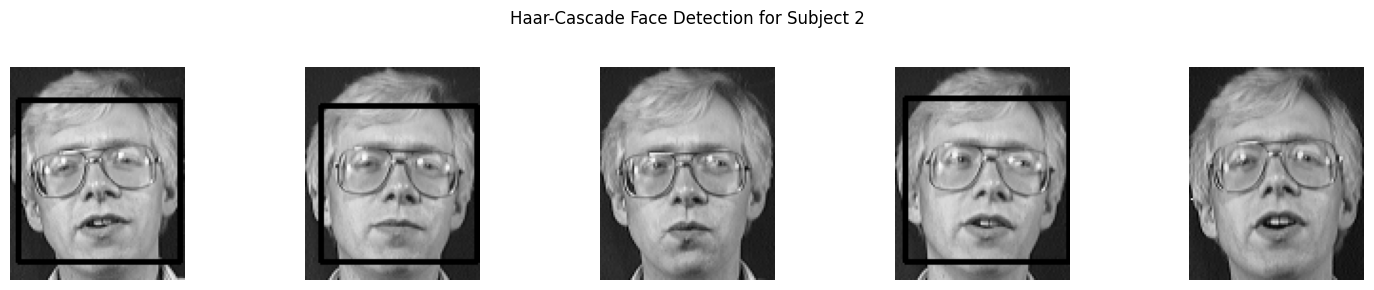

Params: 1.05, 10, (30, 30)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6666666666666666}
Recall: {0.25: 0.6, 0.5: 0.6, 0.75: 0.4}


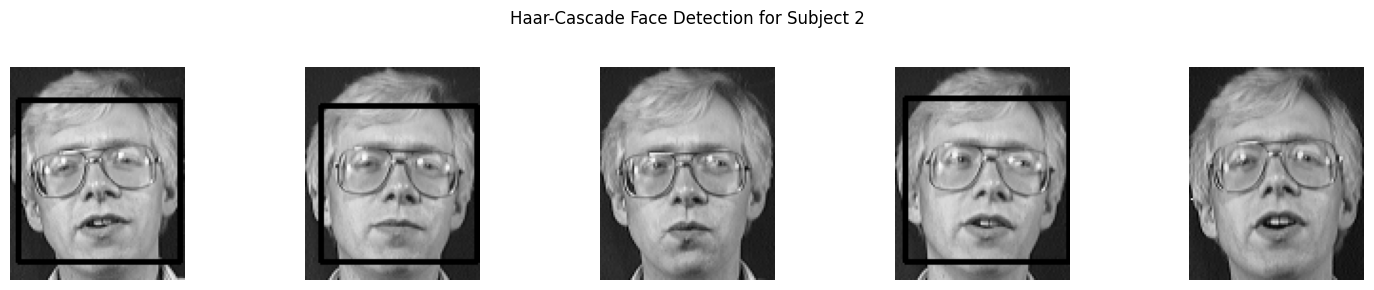

Params: 1.05, 10, (5, 5)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6666666666666666}
Recall: {0.25: 0.6, 0.5: 0.6, 0.75: 0.4}


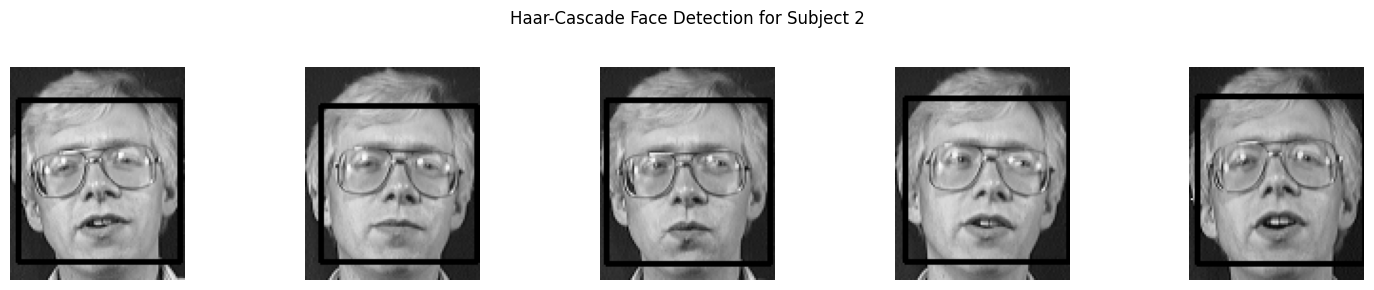

Params: 1.05, 3, (30, 30)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.6}


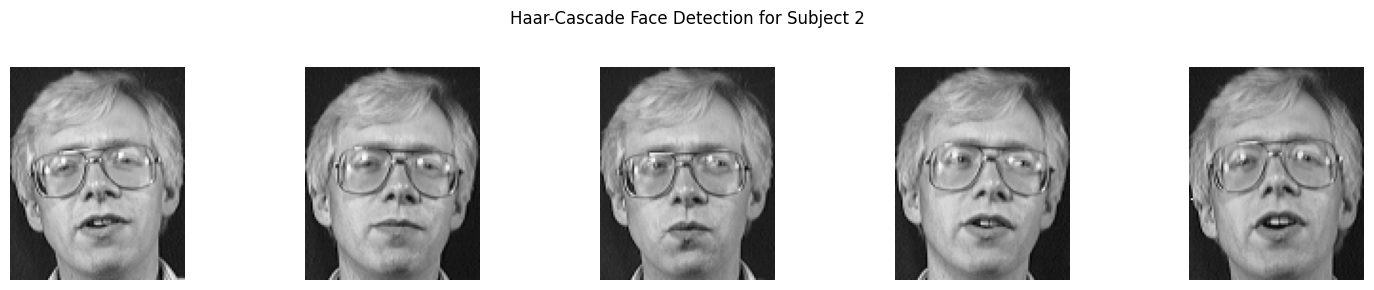

Params: 1.3, 10, (30, 30)
Precision: {0.25: 0, 0.5: 0, 0.75: 0}
Recall: {0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


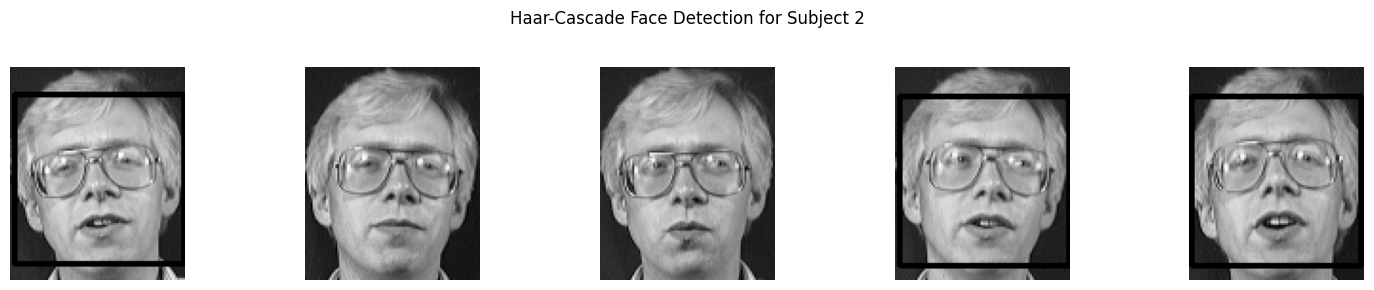

Params: 1.3, 3, (40, 40)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 0.6, 0.5: 0.6, 0.75: 0.0}


In [145]:
params_list = [
    (1.01, 0, (30, 30)),
    (1.01, 5, (30, 30)),
    (1.01, 10, (30, 30)),
    (1.05, 5, (10, 10)),
    (1.05, 10, (30, 30)),
    (1.05, 10, (5, 5)),
    (1.05, 3, (30, 30)),
    (1.3, 10, (30, 30)),
    (1.3, 3, (40, 40))
]


for scaleFactor, minNeighbors, minSize in params_list:
    detections_s2 = haar_cascade_detector(subj = 2, S = S2_processed, M = M, irow = irow2, icol = icol2, scaleFactor = scaleFactor, minNeighbors = minNeighbors, minSize = minSize)
    precision, recall = evaluate_detection(gt_subject2, detections_s2)
    print(f"Params: {scaleFactor}, {minNeighbors}, {minSize}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

In [ ]:
# Precision and Recall


#### **Algorithm 2: Local Binary Pattern (LBP)**

In [117]:
lbp_cascade = cv2.CascadeClassifier('lbpcascade_frontalface.xml')

In [118]:
def detect_faces_lbp(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), maxSize=(200, 200)):
    """
    Perform face detection using LBP cascade.

    Parameters:
    img - grayscale image
    scaleFactor, minNeighbors, minSize, maxSize - detection parameters

    Returns:
    face_boxes - list of bounding boxes (x, y, w, h)
    """
    lbp_cascade = cv2.CascadeClassifier('lbpcascade_frontalface.xml')
    face_boxes = lbp_cascade.detectMultiScale(
        img,
        scaleFactor=scaleFactor,
        minNeighbors=minNeighbors,
        minSize=minSize,
        maxSize=maxSize
    )
    return face_boxes


In [119]:
def evaluate_lbp_on_subject(S_processed, M, irow, icol, scaleFactor, minNeighbors, minSize, maxSize):
    """
    Evaluate LBP detection on a set of processed images.

    Returns:
    detections - list of detected bounding boxes per image
    """
    detections = []

    for i in range(M):
        img_flat = S_processed[:, i]
        img = np.reshape(img_flat, (irow, icol))
        img_uint8 = img.astype(np.uint8)

        face_boxes = detect_faces_lbp(
            img_uint8,
            scaleFactor=scaleFactor,
            minNeighbors=minNeighbors,
            minSize=minSize,
            maxSize=maxSize
        )
        detections.append(face_boxes)

        # Plot detections
        img_with_boxes = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in face_boxes:
            cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img_with_boxes)
        plt.axis('off')
        plt.title(f"Img {i + 1}: {len(face_boxes)} faces")

    plt.suptitle(f"LBP Face Detection - scaleFactor={scaleFactor}, minNeighbors={minNeighbors}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return detections


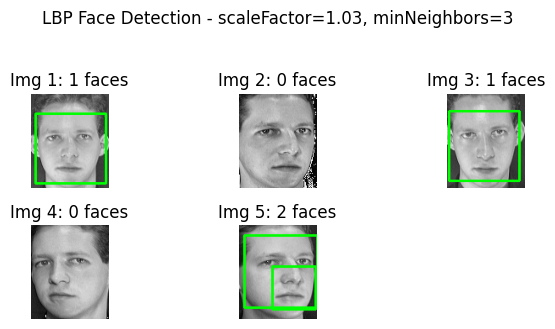

Params: 1.03, 3, (30, 30), (150, 150)
Precision: {0.25: 0.75, 0.5: 0.75, 0.75: 0.75}
Recall: {0.25: 0.6, 0.5: 0.6, 0.75: 0.6}


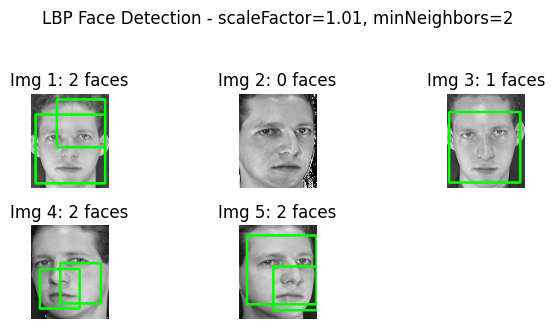

Params: 1.01, 2, (25, 25), (160, 160)
Precision: {0.25: 0.5714285714285714, 0.5: 0.42857142857142855, 0.75: 0.2857142857142857}
Recall: {0.25: 0.8, 0.5: 0.6, 0.75: 0.4}


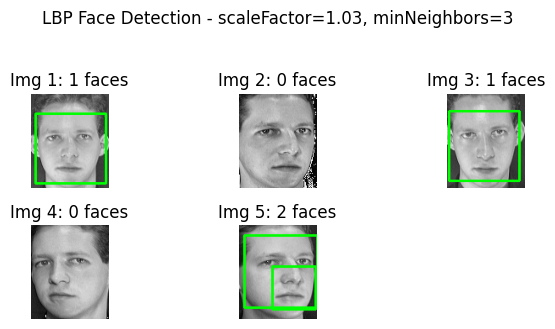

Params: 1.03, 3, (20, 20), (300, 300)
Precision: {0.25: 0.75, 0.5: 0.75, 0.75: 0.75}
Recall: {0.25: 0.6, 0.5: 0.6, 0.75: 0.6}


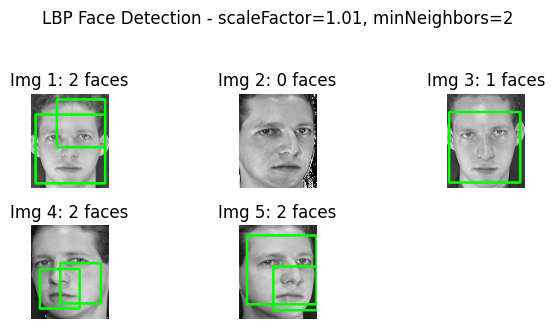

Params: 1.01, 2, (20, 20), (300, 300)
Precision: {0.25: 0.5714285714285714, 0.5: 0.42857142857142855, 0.75: 0.2857142857142857}
Recall: {0.25: 0.8, 0.5: 0.6, 0.75: 0.4}


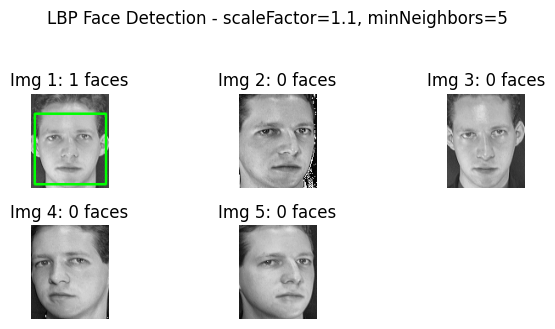

Params: 1.1, 5, (30, 30), (150, 150)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.2}


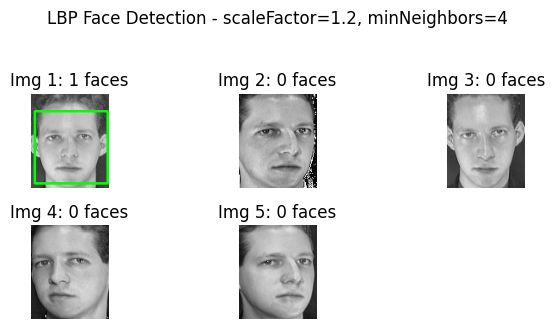

Params: 1.2, 4, (20, 20), (200, 200)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.2}


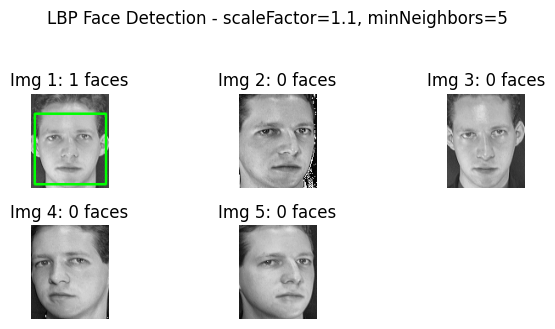

Params: 1.1, 5, (20, 20), (300, 300)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.2}


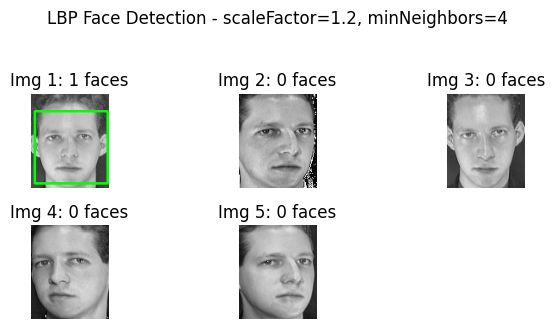

Params: 1.2, 4, (20, 20), (300, 300)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.2}


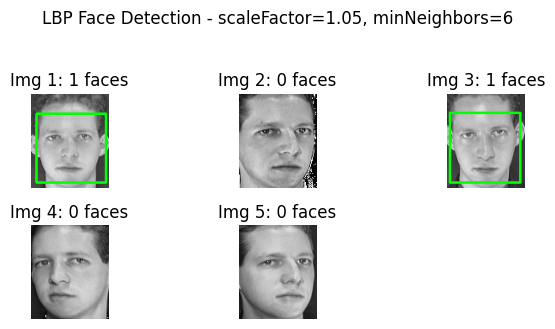

Params: 1.05, 6, (40, 40), (180, 180)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Recall: {0.25: 0.4, 0.5: 0.4, 0.75: 0.4}


In [121]:
params_list = [
    (1.03, 3, (30, 30), (150, 150)),
    (1.01, 2, (25, 25), (160, 160)),
    (1.03, 3, (20, 20), (300, 300)),
    (1.01, 2, (20, 20), (300, 300)),
    (1.1, 5, (30, 30), (150, 150)),
    (1.2, 4, (20, 20), (200, 200)),
    (1.1, 5, (20, 20), (300, 300)),
    (1.2, 4, (20, 20), (300, 300)),
    (1.05, 6, (40, 40), (180, 180))
]

for scaleFactor, minNeighbors, minSize, maxSize in params_list:
    detections_s1 = evaluate_lbp_on_subject(S1_processed, M, irow1, icol1,
                                            scaleFactor, minNeighbors, minSize, maxSize)
    # Do the same for subject 2
    precision, recall = evaluate_detection(gt_subject1, detections_s1)
    print(f"Params: {scaleFactor}, {minNeighbors}, {minSize}, {maxSize}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

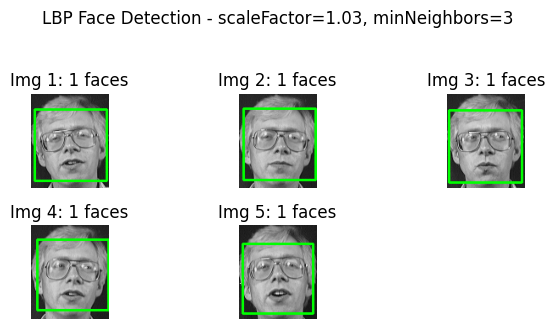

Params: 1.03, 3, (30, 30), (150, 150)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}


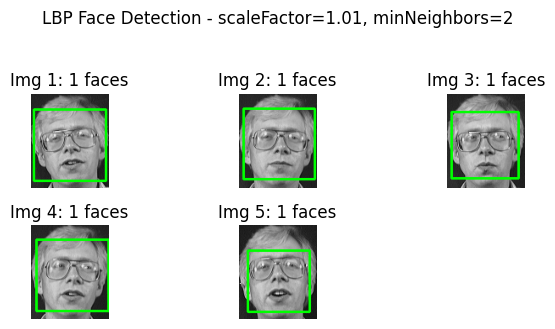

Params: 1.01, 2, (25, 25), (160, 160)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}


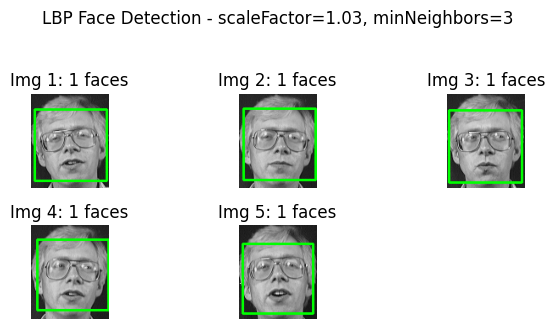

Params: 1.03, 3, (20, 20), (300, 300)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}


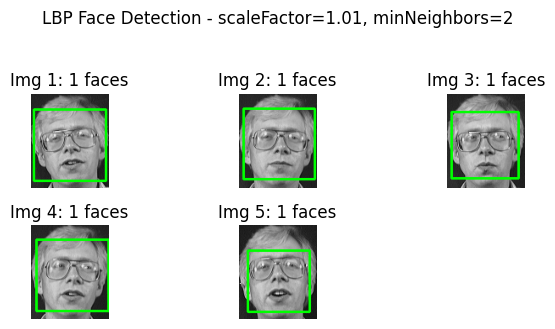

Params: 1.01, 2, (20, 20), (300, 300)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}


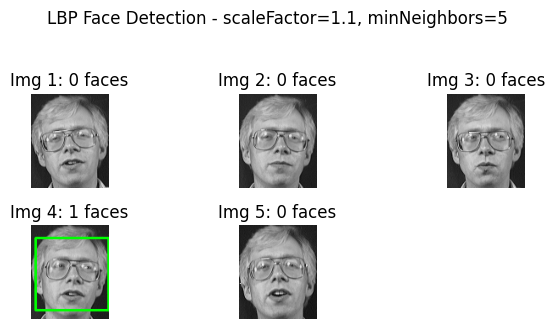

Params: 1.1, 5, (30, 30), (150, 150)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.0}


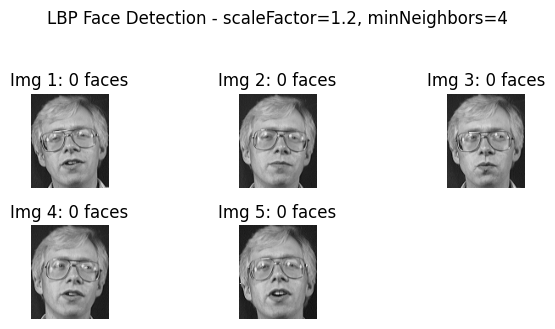

Params: 1.2, 4, (20, 20), (200, 200)
Precision: {0.25: 0, 0.5: 0, 0.75: 0}
Recall: {0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


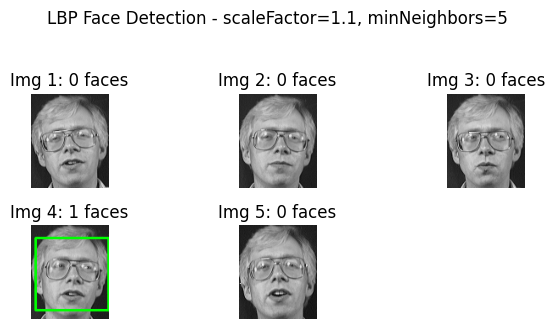

Params: 1.1, 5, (20, 20), (300, 300)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.0}


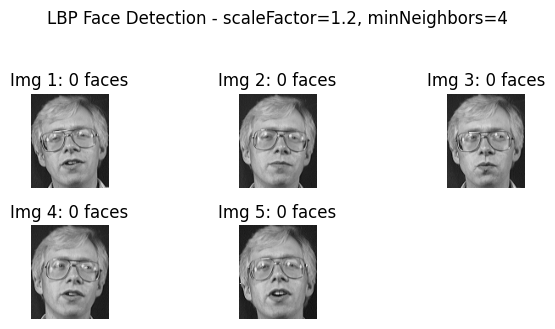

Params: 1.2, 4, (20, 20), (300, 300)
Precision: {0.25: 0, 0.5: 0, 0.75: 0}
Recall: {0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


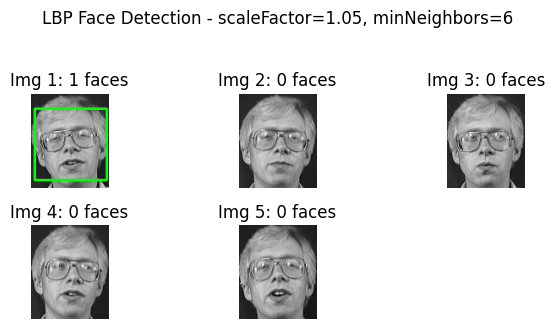

Params: 1.05, 6, (40, 40), (180, 180)
Precision: {0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
Recall: {0.25: 0.2, 0.5: 0.2, 0.75: 0.0}


In [100]:
for scaleFactor, minNeighbors, minSize, maxSize in params_list:
    detections_s2 = evaluate_lbp_on_subject(S2_processed, M, irow2, icol2,
                                            scaleFactor, minNeighbors, minSize, maxSize)
    # Do the same for subject 2
    precision, recall = evaluate_detection(gt_subject2, detections_s2)
    print(f"Params: {scaleFactor}, {minNeighbors}, {minSize}, {maxSize}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")